<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [1]:
!pip install -q gdown torch transformers transformers==4.49 accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [3]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=7fae2b3b-5c09-43da-8356-57ba674d2c22
To: /content/file.csv
100%|██████████| 672M/672M [00:06<00:00, 97.3MB/s]


In [4]:
data.head()

Unnamed: 0    Name   WikiData          City        Lon        Lat  \
0           0  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
1           1  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
2           2  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
3           3  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
4           4  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   

                     description  \
0  спорткомплекс в Екатеринбурге   
1  спорткомплекс в Екатеринбурге   
2  спорткомплекс в Екатеринбурге   
3  спорткомплекс в Екатеринбурге   
4  спорткомплекс в Екатеринбурге   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [5]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [6]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

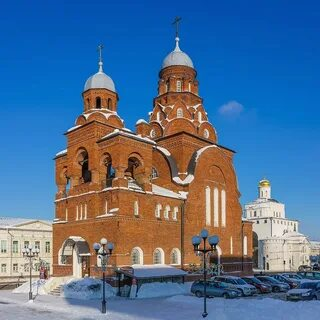

In [7]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   14634 non-null  int64  
 1   Name         14634 non-null  object 
 2   WikiData     12078 non-null  object 
 3   City         14634 non-null  object 
 4   Lon          14634 non-null  float64
 5   Lat          14634 non-null  float64
 6   description  12078 non-null  object 
 7   image        14634 non-null  object 
 8   en_txt       14634 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ MB


In [9]:
data["description"] = data["description"].fillna("")

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
en_txt_corpus = data["en_txt"].tolist()
tf_idf_vectorizer = TfidfVectorizer(stop_words="english")
tf_idf_matrix = tf_idf_vectorizer.fit_transform(en_txt_corpus)

In [12]:
idf = tf_idf_vectorizer.idf_
words = tf_idf_vectorizer.get_feature_names_out()
word_idf = dict(zip(words, idf))

In [13]:
rare_words = sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:800]

In [14]:
bad_keywords = [rare_word[0] for rare_word in rare_words]
mask = data["en_txt"].str.contains("|".join(bad_keywords), case=False, na=False)
data_clean = data[~mask]

In [15]:
data_clean["Place"] = data_clean["Name"] + " " + data_clean["City"]
places = data_clean["Place"].unique()

sampled_data = []
for place in places:
    place_data = data_clean[data_clean["Place"] == place]
    if len(place_data) > 3:
        sampled_data.append(place_data.sample(3))
    else:
        sampled_data.append(place_data)

new_data = pd.concat(sampled_data)

<ipython-input-15-d817b242d39c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Place"] = data_clean["Name"] + " " + data_clean["City"]


Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [16]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["en_txt"], metadata={"source": doc["WikiData"]}) for _, doc in tqdm(new_data.iterrows())
]

0it [00:00, ?it/s]

In [54]:
model_name = "BAAI/bge-small-en"
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

vector_store = FAISS.from_documents(
    RAW_KNOWLEDGE_BASE,
    embeddings,
    distance_strategy=DistanceStrategy.COSINE
)

In [18]:
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

def search_with_reranking(query: str, k: int = 5, rerank_k: int = 3) -> List[Tuple[str, float]]:
    docs_and_scores = vector_store.similarity_search_with_score(query, k=k)

    docs = [doc.page_content for doc, _ in docs_and_scores]
    metadata = [doc.metadata for doc, _ in docs_and_scores]

    reranked_results = reranker.rerank(query, docs, k=rerank_k)

    results = []
    for result in reranked_results:
        doc_text = result['content']
        doc_meta = metadata[docs.index(doc_text)]
        results.append((doc_text, doc_meta))

    return results

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [50]:
model_name = "teknium/OpenHermes-2.5-Mistral-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)

def generate_answer(query: str, context: str) -> str:
    prompt = f"""
    Ответь на вопрос, используя только контекст ниже. Будь точным.
    Контекст: {context}
    Вопрос: {query}
    Ответ:
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=200)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [32]:
from sklearn.decomposition import PCA
from umap import UMAP

sent_model = SentenceTransformer('BAAI/bge-small-en')

txt_embeddings = sent_model.encode(en_txt_corpus)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(txt_embeddings)

umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(txt_embeddings)

df = pd.DataFrame({
    'text': en_txt_corpus,
    'PCA_1': pca_results[:, 0],
    'PCA_2': pca_results[:, 1],
    'UMAP_1': umap_results[:, 0],
    'UMAP_2': umap_results[:, 1]
})

fig_pca = px.scatter(
    df,
    x='PCA_1',
    y='PCA_2',
    hover_name='text',
    title='PCA проекция эмбеддингов',
    width=600,
    height=500,
)
fig_pca.update_traces(marker=dict(size=12))

fig_umap = px.scatter(
    df,
    x='UMAP_1',
    y='UMAP_2',
    hover_name='text',
    title='UMAP проекция эмбеддингов',
    width=600,
    height=500,
)
fig_umap.update_traces(marker=dict(size=12))

fig_pca.show()
fig_umap.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

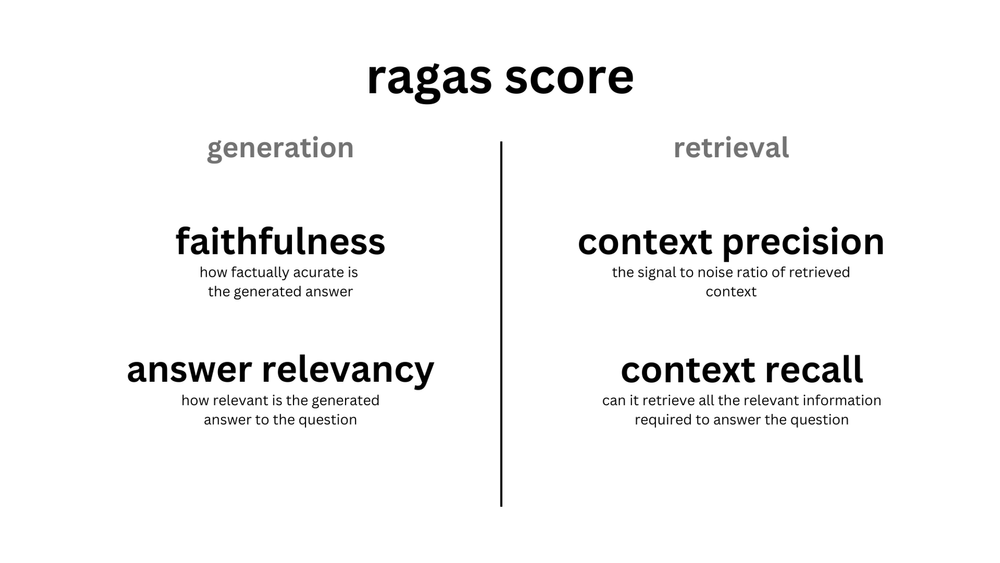

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [47]:
def data_preprocess(df):
  processed_data = []

  for _, row in tqdm(df.iterrows(), total=len(df)):
      description = row.get('en_txt', '')

      question = f"Что вы можете рассказать о {row.get('name', 'этом месте')}?"
      caption = generate_answer(question, description)

      processed_data.append({
          'question': question,
          'ground_truths': [description],
          'answer': caption,
          'contexts': [row.get("description", "")]
      })

  return pd.DataFrame(processed_data)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

def answer_relevancy(questions, answers, batch_size=32):
  scores = []
  sent_model = SentenceTransformer('BAAI/bge-small-en')

  for i in tqdm(range(0, len(questions), batch_size)):
      batch_q = questions[i:i+batch_size]
      batch_a = answers[i:i+batch_size]

      q_embeddings = model.encode(batch_q, convert_to_tensor=True)
      a_embeddings = model.encode(batch_a, convert_to_tensor=True)

      batch_scores = cosine_similarity(q_embeddings.cpu(), a_embeddings.cpu()).diagonal()
      scores.extend(batch_scores)

  return np.array(scores)

# Протестируйте ваш RAG (3 балла)

In [57]:
processed_df = data_preprocess(data_clean)

questions = processed_df['question'].tolist()
answers = processed_df['answer'].tolist()

relevancy_scores = evaluator.answer_relevancy(questions, answers)
processed_df['answer_relevancy'] = relevancy_scores

print(f"Средняя релевантность ответов: {relevancy_scores.mean():.3f}")
print("\nСамые релевантные ответы:")
print(processed_df.sort_values('answer_relevancy', ascending=False).head(3)[['question', 'answer', 'answer_relevancy']])

print("\nНаименее релевантные ответы:")
print(processed_df.sort_values('answer_relevancy').head(3)[['question', 'answer', 'answer_relevancy']])

  0%|          | 0/7986 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


RuntimeError: All input tensors need to be on the same GPU, but found some tensors to not be on a GPU:
 [(torch.Size([1, 8388608]), device(type='cpu')), (torch.Size([262144]), device(type='cpu')), (torch.Size([4096, 4096]), device(type='cpu'))]

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here